<a href="https://colab.research.google.com/github/CoweiChou/Cats_CNNmodel/blob/main/resnet50_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torchsummary import summary

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [ ]:
MODEL_PATH = 'model.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


#### Download Dataset

In [ ]:
# # Download dataset from GoogleDrive
# !pip install --upgrade gdown
# !gdown --fuzzy 1kIef9G5Og7VgDPEHt_vIJMTKHdC7_0Kq --output "./NEU_defect.zip"
# !unzip -q "./NEU_defect.zip"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# zip_file_path = '/content/drive/MyDrive/train400.zip'
# extraction_path = '/content/drive/MyDrive/'  # 更改为您希望解压到的路径
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_path)


In [ ]:
%cd /content/drive/MyDrive/train400

/content/drive/MyDrive/train400


#### Data Process

In [ ]:
IMG_SIZE = 200 # 128
class_names = ['black', 'white', 'orange', 'tuxedo', 'calico', 'tabby','tortoiseshell']
class_map = {name: i for i, name in enumerate(class_names)}
print(class_map)
NUM_CLASS = len(class_names)

{'black': 0, 'white': 1, 'orange': 2, 'tuxedo': 3, 'calico': 4, 'tabby': 5, 'tortoiseshell': 6}


In [ ]:
# search .bmp file paths
paths = glob("/content/drive/MyDrive/train400/*.*")
print("number of samples", len(paths))

number of samples 2993


#### Dataset & Dataloader

In [ ]:
class NEUDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, cls_map, transform):
        self.img_paths = img_paths
        self.img_size = img_size
        self.cls_map = cls_map
        self.transform = transform

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert('RGB')

        # transform img
        img = self.transform(img)

        # Read class index
        cls_name = path.split('/')[-1].split('_')[0]
        cls_idx = self.cls_map[cls_name]
        cls_idx = torch.tensor(cls_idx, dtype=torch.int64)
        return img, cls_idx

In [ ]:
# split dataset
train_paths, val_paths = train_test_split(paths,
    random_state=556,
    test_size=0.2)

len(train_paths), len(val_paths)

(2394, 599)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

# Preprocess Transform
transform =  ResNet50_Weights.DEFAULT.transforms()


# 定義數據增強函數
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Build Dataset
train_ds = NEUDataset(train_paths, IMG_SIZE, class_map,
                      transform)
val_ds = NEUDataset(val_paths, IMG_SIZE, class_map,
                    transform)

In [ ]:
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Build dataloader
BS = 32
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

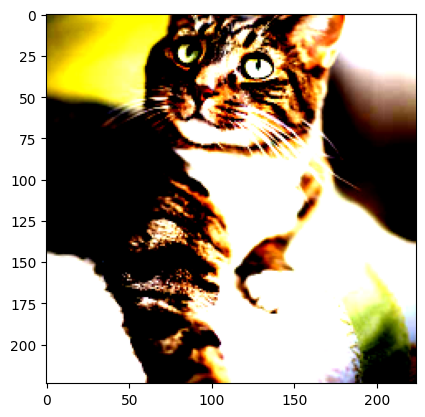

(224, 224, 3)


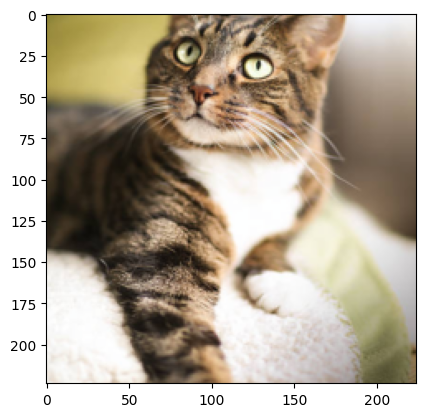

Class: tensor(5)


In [ ]:
# Visulize sample
idx = np.random.randint(0, len(train_ds))
img, cls = train_ds[idx]

img_normalized = img.permute(1, 2, 0)
plt.imshow(img_normalized)
plt.show()

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
print(img_raw.shape)
plt.imshow(img_raw)
plt.show()

print('Class:', cls)

#### Build Model

Pick your favorite models: https://pytorch.org/vision/stable/models.html

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# replace classifier
num_features = model.fc.in_features # len of feature vectors

# # Freeze model
# for param in model.parameters():
#     param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(num_features, 7)
print(model.fc)


Linear(in_features=2048, out_features=7, bias=True)


In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Training

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

```python
from torchvision.models import resnet50, ResNet50_Weights

resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet50(weights=ResNet50_Weights.DEFAULT)

# Strings are also supported
resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
resnet50(weights=None)

# Old version
# pretrained weights:
resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50(weights="IMAGENET1K_V1")
resnet50(pretrained=True)  # deprecated
resnet50(True)  # deprecated

# no weights:
resnet50(weights=None)
resnet50()
resnet50(pretrained=False)  # deprecated
resnet50(False)  # deprecated
```

In [ ]:
def train(pretrained, freeze=False):
    # Model
    if pretrained:
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        model = models.resnet50(weights=None)

    if freeze:
        # Freeze model
        for param in model.parameters():
            param.requires_grad = False
    # Replace classifier
    num_features = model.fc.in_features # len of feature vectors
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model = model.to(device)
    # print(model)

    loss_fn = nn.CrossEntropyLoss()
    # lower learning rate for finetuning
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    EPOCHS = 50
    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()

    # Save model
    # torch.save(model, MODEL_PATH)

    new_model_name = "resnet50.pth"  # 指定自定义的模型文件名
    torch.save(model, new_model_name)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 1.8358, train_acc: 0.269         val_loss: 1.8493, val_acc: 0.304 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 1.4982, train_acc: 0.431         val_loss: 1.4997, val_acc: 0.457 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 1.3122, train_acc: 0.515         val_loss: 1.2413, val_acc: 0.558 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 1.1340, train_acc: 0.587         val_loss: 1.2388, val_acc: 0.551 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 1.0420, train_acc: 0.626         val_loss: 1.3451, val_acc: 0.529 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.9402, train_acc: 0.665         val_loss: 1.2296, val_acc: 0.648 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.8369, train_acc: 0.706         val_loss: 1.4162, val_acc: 0.543 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.7677, train_acc: 0.726         val_loss: 0.8859, val_acc: 0.689 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.6224, train_acc: 0.772         val_loss: 1.9942, val_acc: 0.566 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.5697, train_acc: 0.801         val_loss: 1.0677, val_acc: 0.653 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.5317, train_acc: 0.812         val_loss: 1.2013, val_acc: 0.669 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.4641, train_acc: 0.840         val_loss: 1.2630, val_acc: 0.631 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.3387, train_acc: 0.890         val_loss: 1.0116, val_acc: 0.733 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.3075, train_acc: 0.900         val_loss: 1.7524, val_acc: 0.583 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.2688, train_acc: 0.908         val_loss: 2.5607, val_acc: 0.593 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.2752, train_acc: 0.908         val_loss: 1.0734, val_acc: 0.683 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.2067, train_acc: 0.929         val_loss: 2.0043, val_acc: 0.581 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.1903, train_acc: 0.938         val_loss: 1.5115, val_acc: 0.636 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.2316, train_acc: 0.918         val_loss: 1.1219, val_acc: 0.683 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.1496, train_acc: 0.947         val_loss: 0.9746, val_acc: 0.731 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.1400, train_acc: 0.947         val_loss: 1.3350, val_acc: 0.726 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0021         train_loss: 0.1314, train_acc: 0.956         val_loss: 1.4312, val_acc: 0.663 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0022         train_loss: 0.1373, train_acc: 0.952         val_loss: 1.5969, val_acc: 0.693 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0023         train_loss: 0.1200, train_acc: 0.960         val_loss: 1.0888, val_acc: 0.733 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0024         train_loss: 0.1186, train_acc: 0.959         val_loss: 1.7036, val_acc: 0.674 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0025         train_loss: 0.1235, train_acc: 0.957         val_loss: 1.3694, val_acc: 0.653 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0026         train_loss: 0.1136, train_acc: 0.960         val_loss: 1.1154, val_acc: 0.735 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0027         train_loss: 0.0733, train_acc: 0.978         val_loss: 1.2532, val_acc: 0.738 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0028         train_loss: 0.0550, train_acc: 0.982         val_loss: 1.3930, val_acc: 0.696 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0029         train_loss: 0.0599, train_acc: 0.980         val_loss: 1.0952, val_acc: 0.736 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0030         train_loss: 0.0445, train_acc: 0.987         val_loss: 1.3615, val_acc: 0.711 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0031         train_loss: 0.0987, train_acc: 0.962         val_loss: 1.4439, val_acc: 0.681 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0032         train_loss: 0.1311, train_acc: 0.956         val_loss: 1.9859, val_acc: 0.616 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0033         train_loss: 0.1700, train_acc: 0.948         val_loss: 1.2899, val_acc: 0.711 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0034         train_loss: 0.0921, train_acc: 0.971         val_loss: 1.1214, val_acc: 0.718 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0035         train_loss: 0.0567, train_acc: 0.982         val_loss: 1.2655, val_acc: 0.745 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0036         train_loss: 0.0336, train_acc: 0.990         val_loss: 1.0926, val_acc: 0.748 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0037         train_loss: 0.0341, train_acc: 0.990         val_loss: 1.0362, val_acc: 0.765 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0038         train_loss: 0.0360, train_acc: 0.989         val_loss: 1.1806, val_acc: 0.750 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0039         train_loss: 0.0427, train_acc: 0.988         val_loss: 1.7138, val_acc: 0.683 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0040         train_loss: 0.0336, train_acc: 0.991         val_loss: 1.2238, val_acc: 0.741 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0041         train_loss: 0.0505, train_acc: 0.983         val_loss: 1.8782, val_acc: 0.669 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0042         train_loss: 0.1259, train_acc: 0.962         val_loss: 1.7228, val_acc: 0.689 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0043         train_loss: 0.0882, train_acc: 0.970         val_loss: 1.3366, val_acc: 0.668 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0044         train_loss: 0.0385, train_acc: 0.989         val_loss: 1.2722, val_acc: 0.736 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0045         train_loss: 0.0346, train_acc: 0.989         val_loss: 1.1751, val_acc: 0.756 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0046         train_loss: 0.0307, train_acc: 0.991         val_loss: 1.2243, val_acc: 0.728 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0047         train_loss: 0.0235, train_acc: 0.993         val_loss: 1.3014, val_acc: 0.728 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0048         train_loss: 0.0409, train_acc: 0.985         val_loss: 1.4790, val_acc: 0.698 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0049         train_loss: 0.0626, train_acc: 0.981         val_loss: 1.8854, val_acc: 0.668 


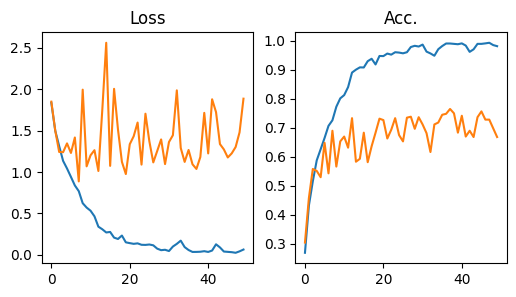

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 0.7602, train_acc: 0.832         val_loss: 0.1436, val_acc: 0.968 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 0.1108, train_acc: 0.968         val_loss: 0.0862, val_acc: 0.975 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.0341, train_acc: 0.995         val_loss: 0.0599, val_acc: 0.980 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.0229, train_acc: 0.994         val_loss: 0.0786, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.0199, train_acc: 0.997         val_loss: 0.0698, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.0125, train_acc: 0.998         val_loss: 0.0729, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.0299, train_acc: 0.990         val_loss: 0.1243, val_acc: 0.962 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.0252, train_acc: 0.992         val_loss: 0.0641, val_acc: 0.982 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.0090, train_acc: 0.997         val_loss: 0.0668, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.0056, train_acc: 0.998         val_loss: 0.0894, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.0110, train_acc: 0.996         val_loss: 0.1126, val_acc: 0.968 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.0165, train_acc: 0.995         val_loss: 0.1238, val_acc: 0.965 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.0125, train_acc: 0.997         val_loss: 0.0678, val_acc: 0.980 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.0113, train_acc: 0.997         val_loss: 0.0606, val_acc: 0.983 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.0142, train_acc: 0.996         val_loss: 0.1031, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.0107, train_acc: 0.997         val_loss: 0.0771, val_acc: 0.978 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.0073, train_acc: 0.999         val_loss: 0.0640, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.0035, train_acc: 0.999         val_loss: 0.0604, val_acc: 0.980 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.0039, train_acc: 0.999         val_loss: 0.0744, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.0087, train_acc: 0.999         val_loss: 0.0760, val_acc: 0.972 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.0043, train_acc: 0.999         val_loss: 0.0562, val_acc: 0.982 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0021         train_loss: 0.0017, train_acc: 1.000         val_loss: 0.0664, val_acc: 0.987 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0022         train_loss: 0.0031, train_acc: 0.999         val_loss: 0.0865, val_acc: 0.975 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0023         train_loss: 0.0013, train_acc: 1.000         val_loss: 0.0912, val_acc: 0.968 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0024         train_loss: 0.0059, train_acc: 0.999         val_loss: 0.1028, val_acc: 0.963 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0025         train_loss: 0.0012, train_acc: 1.000         val_loss: 0.0778, val_acc: 0.975 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0026         train_loss: 0.0248, train_acc: 0.995         val_loss: 0.1519, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0027         train_loss: 0.0198, train_acc: 0.994         val_loss: 0.1209, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0028         train_loss: 0.0211, train_acc: 0.994         val_loss: 0.1062, val_acc: 0.968 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0029         train_loss: 0.0194, train_acc: 0.993         val_loss: 0.1071, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0030         train_loss: 0.0036, train_acc: 1.000         val_loss: 0.0894, val_acc: 0.970 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0031         train_loss: 0.0051, train_acc: 0.998         val_loss: 0.0984, val_acc: 0.968 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0032         train_loss: 0.0091, train_acc: 0.998         val_loss: 0.0900, val_acc: 0.975 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0033         train_loss: 0.0134, train_acc: 0.997         val_loss: 0.0899, val_acc: 0.978 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0034         train_loss: 0.0031, train_acc: 1.000         val_loss: 0.1365, val_acc: 0.962 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0035         train_loss: 0.0052, train_acc: 0.999         val_loss: 0.1085, val_acc: 0.975 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0036         train_loss: 0.0014, train_acc: 1.000         val_loss: 0.1161, val_acc: 0.977 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0037         train_loss: 0.0014, train_acc: 1.000         val_loss: 0.1120, val_acc: 0.973 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0038         train_loss: 0.0041, train_acc: 0.999         val_loss: 0.1174, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0039         train_loss: 0.0008, train_acc: 1.000         val_loss: 0.1180, val_acc: 0.970 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0040         train_loss: 0.0006, train_acc: 1.000         val_loss: 0.1113, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0041         train_loss: 0.0007, train_acc: 1.000         val_loss: 0.1289, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0042         train_loss: 0.0003, train_acc: 1.000         val_loss: 0.1099, val_acc: 0.970 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0043         train_loss: 0.0003, train_acc: 1.000         val_loss: 0.1149, val_acc: 0.972 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0044         train_loss: 0.0002, train_acc: 1.000         val_loss: 0.1051, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0045         train_loss: 0.0017, train_acc: 0.999         val_loss: 0.1126, val_acc: 0.970 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0046         train_loss: 0.0009, train_acc: 1.000         val_loss: 0.1071, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0047         train_loss: 0.0003, train_acc: 1.000         val_loss: 0.1047, val_acc: 0.963 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0048         train_loss: 0.0003, train_acc: 1.000         val_loss: 0.0995, val_acc: 0.967 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0049         train_loss: 0.0002, train_acc: 1.000         val_loss: 0.1050, val_acc: 0.968 


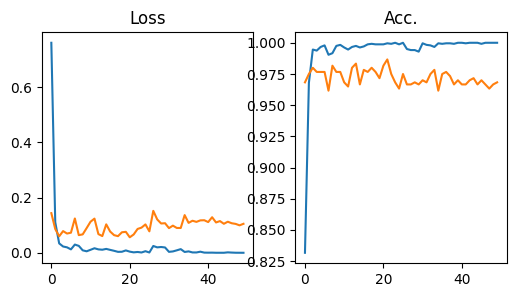

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 1.8131, train_acc: 0.482         val_loss: 1.6934, val_acc: 0.696 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 1.5856, train_acc: 0.792         val_loss: 1.4878, val_acc: 0.821 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 1.3949, train_acc: 0.862         val_loss: 1.3274, val_acc: 0.885 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 1.2359, train_acc: 0.880         val_loss: 1.1785, val_acc: 0.895 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 1.1001, train_acc: 0.895         val_loss: 1.0482, val_acc: 0.905 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.9931, train_acc: 0.901         val_loss: 0.9380, val_acc: 0.912 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.8951, train_acc: 0.913         val_loss: 0.8668, val_acc: 0.917 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.8206, train_acc: 0.915         val_loss: 0.7845, val_acc: 0.927 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.7528, train_acc: 0.918         val_loss: 0.7454, val_acc: 0.933 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.6960, train_acc: 0.919         val_loss: 0.6892, val_acc: 0.932 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.6566, train_acc: 0.925         val_loss: 0.6341, val_acc: 0.933 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.6074, train_acc: 0.929         val_loss: 0.6016, val_acc: 0.935 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.5725, train_acc: 0.933         val_loss: 0.5667, val_acc: 0.937 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.5520, train_acc: 0.931         val_loss: 0.5507, val_acc: 0.933 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.5115, train_acc: 0.938         val_loss: 0.5121, val_acc: 0.933 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0015         train_loss: 0.4859, train_acc: 0.939         val_loss: 0.4951, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0016         train_loss: 0.4699, train_acc: 0.932         val_loss: 0.4826, val_acc: 0.937 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0017         train_loss: 0.4459, train_acc: 0.944         val_loss: 0.4466, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0018         train_loss: 0.4178, train_acc: 0.947         val_loss: 0.4379, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0019         train_loss: 0.4085, train_acc: 0.942         val_loss: 0.4182, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0020         train_loss: 0.3866, train_acc: 0.950         val_loss: 0.4083, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0021         train_loss: 0.3765, train_acc: 0.949         val_loss: 0.3932, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0022         train_loss: 0.3716, train_acc: 0.950         val_loss: 0.3927, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0023         train_loss: 0.3560, train_acc: 0.949         val_loss: 0.3748, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0024         train_loss: 0.3413, train_acc: 0.952         val_loss: 0.3640, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0025         train_loss: 0.3333, train_acc: 0.958         val_loss: 0.3515, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0026         train_loss: 0.3145, train_acc: 0.962         val_loss: 0.3438, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0027         train_loss: 0.3073, train_acc: 0.960         val_loss: 0.3380, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0028         train_loss: 0.3004, train_acc: 0.961         val_loss: 0.3317, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0029         train_loss: 0.2813, train_acc: 0.963         val_loss: 0.3224, val_acc: 0.938 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0030         train_loss: 0.2794, train_acc: 0.958         val_loss: 0.3117, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0031         train_loss: 0.2752, train_acc: 0.960         val_loss: 0.3056, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0032         train_loss: 0.2636, train_acc: 0.960         val_loss: 0.3058, val_acc: 0.938 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0033         train_loss: 0.2593, train_acc: 0.963         val_loss: 0.2958, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0034         train_loss: 0.2645, train_acc: 0.961         val_loss: 0.2903, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0035         train_loss: 0.2462, train_acc: 0.967         val_loss: 0.2790, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0036         train_loss: 0.2399, train_acc: 0.967         val_loss: 0.2750, val_acc: 0.948 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0037         train_loss: 0.2382, train_acc: 0.970         val_loss: 0.2753, val_acc: 0.938 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0038         train_loss: 0.2387, train_acc: 0.965         val_loss: 0.2656, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0039         train_loss: 0.2306, train_acc: 0.966         val_loss: 0.2738, val_acc: 0.940 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0040         train_loss: 0.2184, train_acc: 0.965         val_loss: 0.2631, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0041         train_loss: 0.2142, train_acc: 0.969         val_loss: 0.2591, val_acc: 0.942 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0042         train_loss: 0.2037, train_acc: 0.968         val_loss: 0.2569, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0043         train_loss: 0.2019, train_acc: 0.972         val_loss: 0.2494, val_acc: 0.943 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0044         train_loss: 0.1979, train_acc: 0.975         val_loss: 0.2412, val_acc: 0.948 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0045         train_loss: 0.1981, train_acc: 0.974         val_loss: 0.2446, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0046         train_loss: 0.1946, train_acc: 0.970         val_loss: 0.2413, val_acc: 0.947 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0047         train_loss: 0.1896, train_acc: 0.975         val_loss: 0.2352, val_acc: 0.945 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0048         train_loss: 0.1848, train_acc: 0.974         val_loss: 0.2409, val_acc: 0.948 


  0%|          | 0/75 [00:00<?, ?it/s]

EPOCH: 0049         train_loss: 0.1843, train_acc: 0.970         val_loss: 0.2341, val_acc: 0.945 


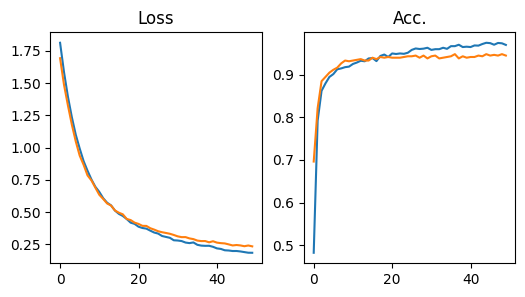

In [ ]:
train(pretrained=False)
train(pretrained=True)
train(pretrained=True, freeze=True)


#### Ref:

[Official: Transfer learning tutorials](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Official: Finetuning torchvision models tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#load-data)

[Accessing-and-modifying-different-layers-of-a-pretrained-model-in-pytorch](https://github.com/mortezamg63/Accessing-and-modifying-different-layers-of-a-pretrained-model-in-pytorch)